In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Function to prepare the dataset for modeling
def prepare_dataset(data, target_col, n_lags=4, n_ahead=10):
    X, y = [], []
    for i in range(n_lags, len(data) - n_ahead):
        X.append(np.hstack([
            data[target_col].values[i - n_lags:i],  # lags of target
            data.drop(columns=[target_col]).values[i]  # current exogenous variables
        ]))
        y.append(data[target_col].values[i:i + n_ahead])  # next n_ahead steps
    return np.array(X), np.array(y)

# List to store datasets
datasets = []

# ==========================
# Univariate Time Series
# ==========================

# 1. AirPassengers Dataset
print("Loading AirPassengers dataset...")
air_passengers = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv',
                             parse_dates=['Month'], index_col='Month')
air_passengers.rename(columns={'Passengers': 'y'}, inplace=True)
air_passengers['X'] = 0  # Placeholder for exogenous variable
datasets.append(('AirPassengers', air_passengers))

# 2. Sunspots Dataset
print("Loading Sunspots dataset...")
sunspots = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv',
                       parse_dates=['Month'], index_col='Month')
sunspots.rename(columns={'Sunspots': 'y'}, inplace=True)
sunspots['X'] = 0  # Placeholder for exogenous variable
datasets.append(('Sunspots', sunspots))

# ==========================
# Multivariate Time Series
# ==========================

# 3. Electricity Consumption Dataset (Household Power Consumption)
print("Loading Electricity Consumption dataset...")
power = pd.read_csv("https://raw.githubusercontent.com/sajalsuhane/household_power_consumption/master/household_power_consumption.csv",
                    parse_dates=['Date'], index_col='Date', na_values='?')
power.rename(columns={'Global_active_power': 'y'}, inplace=True)
power.fillna(method='ffill', inplace=True)
power['X'] = power['Global_reactive_power']
datasets.append(('ElectricityConsumption', power[['y', 'X']]))

# 4. Weather Dataset (Daily Max Temperatures)
print("Loading Daily Max Temperatures dataset...")
temperatures = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv',
                           parse_dates=['Date'], index_col='Date')
temperatures.rename(columns={'Temp': 'y'}, inplace=True)
temperatures['X'] = 0  # Placeholder for exogenous variable
datasets.append(('DailyMaxTemperatures', temperatures))



Loading AirPassengers dataset...
Loading Sunspots dataset...
Loading Electricity Consumption dataset...
Loading Daily Max Temperatures dataset...


In [12]:
datasets

[('AirPassengers',
                y  X
  Month             
  1949-01-01  112  0
  1949-02-01  118  0
  1949-03-01  132  0
  1949-04-01  129  0
  1949-05-01  121  0
  ...         ... ..
  1960-08-01  606  0
  1960-09-01  508  0
  1960-10-01  461  0
  1960-11-01  390  0
  1960-12-01  432  0
  
  [144 rows x 2 columns]),
 ('Sunspots',
                 y  X
  Month              
  1749-01-01  58.0  0
  1749-02-01  62.6  0
  1749-03-01  70.0  0
  1749-04-01  55.7  0
  1749-05-01  85.0  0
  ...          ... ..
  1983-08-01  71.8  0
  1983-09-01  50.3  0
  1983-10-01  55.8  0
  1983-11-01  33.3  0
  1983-12-01  33.4  0
  
  [2820 rows x 2 columns]),
 ('ElectricityConsumption',
                  y      X
  Date                    
  2016-12-16  4.216  0.418
  2016-12-16  5.360  0.436
  2016-12-16  5.374  0.498
  2016-12-16  5.388  0.502
  2016-12-16  3.666  0.528
  ...           ...    ...
  2017-08-06  0.326  0.098
  2017-08-06  0.306  0.094
  2017-08-06  0.344  0.106
  2017-08-06  0.416  0


Processing AirPassengers dataset...

Results for AirPassengers dataset:
Native Multioutput RandomForestRegressor:
Average MSE: 5327.9867
Average MAPE: 0.1630

MultiOutputRegressor with RandomForestRegressor:
Average MSE: 4846.6391
Average MAPE: 0.1533


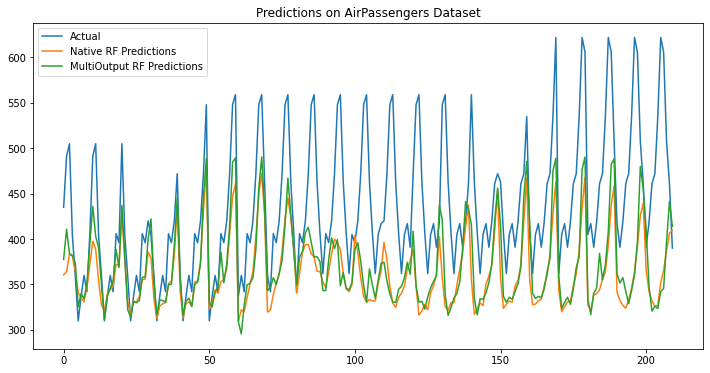


Processing Sunspots dataset...


KeyboardInterrupt: 

In [11]:

# ==========================
# Modeling and Evaluation
# ==========================

for name, data in datasets[:2]:
    print(f"\nProcessing {name} dataset...")
    # Prepare the dataset
    n_lags = 7
    n_ahead = 10
    X, y = prepare_dataset(data, 'y', n_lags, n_ahead)
    
    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize lists to store errors
    mse_native_list, mape_native_list = [], []
    mse_multioutput_list, mape_multioutput_list = [], []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # 2.a Native multioutput capability
        rf_native = RandomForestRegressor(n_estimators=100, random_state=0)
        rf_native.fit(X_train, y_train)
        y_pred_native = rf_native.predict(X_test)
        
        # 2.b Using MultiOutputRegressor
        rf_base = RandomForestRegressor(n_estimators=100, random_state=0)
        rf_multioutput = MultiOutputRegressor(rf_base)
        rf_multioutput.fit(X_train, y_train)
        y_pred_multioutput = rf_multioutput.predict(X_test)
        
        # 3. Compute MSE and MAPE
        mse_native = mean_squared_error(y_test, y_pred_native)
        mape_native = mean_absolute_percentage_error(y_test, y_pred_native)
        mse_multioutput = mean_squared_error(y_test, y_pred_multioutput)
        mape_multioutput = mean_absolute_percentage_error(y_test, y_pred_multioutput)
        
        mse_native_list.append(mse_native)
        mape_native_list.append(mape_native)
        mse_multioutput_list.append(mse_multioutput)
        mape_multioutput_list.append(mape_multioutput)
    
    # Compute average errors
    avg_mse_native = np.mean(mse_native_list)
    avg_mape_native = np.mean(mape_native_list)
    avg_mse_multioutput = np.mean(mse_multioutput_list)
    avg_mape_multioutput = np.mean(mape_multioutput_list)
    
    print(f"\nResults for {name} dataset:")
    print("Native Multioutput RandomForestRegressor:")
    print(f"Average MSE: {avg_mse_native:.4f}")
    print(f"Average MAPE: {avg_mape_native:.4f}")
    
    print("\nMultiOutputRegressor with RandomForestRegressor:")
    print(f"Average MSE: {avg_mse_multioutput:.4f}")
    print(f"Average MAPE: {avg_mape_multioutput:.4f}")

    # Optional: Plot the predictions of the last fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_test.flatten())), y_test.flatten(), label='Actual')
    plt.plot(range(len(y_pred_native.flatten())), y_pred_native.flatten(), label='Native RF Predictions')
    plt.plot(range(len(y_pred_multioutput.flatten())), y_pred_multioutput.flatten(), label='MultiOutput RF Predictions')
    plt.title(f'Predictions on {name} Dataset')
    plt.legend()
    plt.show()


In [ ]:

# ==========================
# Modeling and Evaluation
# ==========================

for name, data in datasets[3:]:
    print(f"\nProcessing {name} dataset...")
    # Prepare the dataset
    n_lags = 4
    n_ahead = 10
    X, y = prepare_dataset(data, 'y', n_lags, n_ahead)
    
    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize lists to store errors
    mse_native_list, mape_native_list = [], []
    mse_multioutput_list, mape_multioutput_list = [], []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # 2.a Native multioutput capability
        rf_native = RandomForestRegressor(n_estimators=100, random_state=0)
        rf_native.fit(X_train, y_train)
        y_pred_native = rf_native.predict(X_test)
        
        # 2.b Using MultiOutputRegressor
        rf_base = RandomForestRegressor(n_estimators=100, random_state=0)
        rf_multioutput = MultiOutputRegressor(rf_base)
        rf_multioutput.fit(X_train, y_train)
        y_pred_multioutput = rf_multioutput.predict(X_test)
        
        # 3. Compute MSE and MAPE
        mse_native = mean_squared_error(y_test, y_pred_native)
        mape_native = mean_absolute_percentage_error(y_test, y_pred_native)
        mse_multioutput = mean_squared_error(y_test, y_pred_multioutput)
        mape_multioutput = mean_absolute_percentage_error(y_test, y_pred_multioutput)
        
        mse_native_list.append(mse_native)
        mape_native_list.append(mape_native)
        mse_multioutput_list.append(mse_multioutput)
        mape_multioutput_list.append(mape_multioutput)
    
    # Compute average errors
    avg_mse_native = np.mean(mse_native_list)
    avg_mape_native = np.mean(mape_native_list)
    avg_mse_multioutput = np.mean(mse_multioutput_list)
    avg_mape_multioutput = np.mean(mape_multioutput_list)
    
    print(f"\nResults for {name} dataset:")
    print("Native Multioutput RandomForestRegressor:")
    print(f"Average MSE: {avg_mse_native:.4f}")
    print(f"Average MAPE: {avg_mape_native:.4f}")
    
    print("\nMultiOutputRegressor with RandomForestRegressor:")
    print(f"Average MSE: {avg_mse_multioutput:.4f}")
    print(f"Average MAPE: {avg_mape_multioutput:.4f}")

    # Optional: Plot the predictions of the last fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_test.flatten())), y_test.flatten(), label='Actual')
    plt.plot(range(len(y_pred_native.flatten())), y_pred_native.flatten(), label='Native RF Predictions')
    plt.plot(range(len(y_pred_multioutput.flatten())), y_pred_multioutput.flatten(), label='MultiOutput RF Predictions')
    plt.title(f'Predictions on {name} Dataset')
    plt.legend()
    plt.show()
